<a href="https://colab.research.google.com/github/gustavor10silva/alura_imersao_dados_4/blob/main/4_modelo_de_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import math

from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif, f_regression

import xgboost as xgb

from sklearn.metrics import make_scorer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Preparando os dados

De início, temos a seguinte base de dados:

In [ ]:
df_imoveis_ibge = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_imoveis_ibge_v4.csv')
df_imoveis_ibge.drop(columns = ['Unnamed: 0'], inplace = True)
df_imoveis_ibge.head()

,endereco,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,endereco_geolocalizado,...,domicilio01_sp1_V002,V012,domicilio01_sp1_V017,domicilio01_sp1_V023,domicilio01_sp1_V035,domicilio01_sp1_V043,pessoa01_sp1_Cod_setor,pessoa01_sp1_V001,pessoa03_sp1_Cod_setor,pessoa03_sp1_V001
0,"Rua Caramuru, 100 - Saúde, São Paulo","Rua Caramuru, 100",Saúde,São Paulo,380,9,4,4,3700000,"100, Rua Caramuru, Chácara Inglesa, Saúde, São...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Alameda Franca, 587 - Jardim Paulista, São Paulo","Alameda Franca, 587",Jardim Paulista,São Paulo,137,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Alameda Franca, 587 - Jardim Paulista, São Paulo","Alameda Franca, 587",Jardim Paulista,São Paulo,142,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Alameda Franca - Jardim Paulista, São Paulo",Alameda Franca,Jardim Paulista,São Paulo,150,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Alameda Franca - Jardim Paulista, São Paulo",Alameda Franca,Jardim Paulista,São Paulo,155,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cada bairro de São Paulo pertence a um distrito. Cada distrito engloba vários bairros.

Agora, levarei a base acima para o Google Sheets e vou inserir mais algumas variáveis relacionadas ao distrito que o bairro pertence. São elas:

* IDH do distrito
* Área do distrito
* População do distrito
* Densidade demografica do distrito

Também foram inseridas as variáveis relacionadas ao bairro:

* Preço do $m^2$ por bairro
* Preço médio de um imóvel por bairro
* Estimativa de preço do imóvel usando área e preço do $m^2$

O dataset com essas novas variáveis ficou assim:

In [ ]:
df_imoveis_ibge_novo = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/analise_resultados_imoveis - Dataset Novo V4.csv')
df_imoveis_ibge_novo.drop(columns = ['Unnamed: 0'], inplace = True)
df_imoveis_ibge_novo

,endereco,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,endereco_geolocalizado,...,pessoa03_sp1_Cod_setor,pessoa03_sp1_V001,distrito,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,"Rua Caramuru, 100 - Saúde, São Paulo","Rua Caramuru, 100",Saúde,São Paulo,380,9,4,4,3700000,"100, Rua Caramuru, Chácara Inglesa, Saúde, São...",...,NaN,NaN,Saúde,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,"Alameda Franca, 587 - Jardim Paulista, São Paulo","Alameda Franca, 587",Jardim Paulista,São Paulo,137,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,Pinheiros,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,"Alameda Franca, 587 - Jardim Paulista, São Paulo","Alameda Franca, 587",Jardim Paulista,São Paulo,142,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,Pinheiros,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,"Alameda Franca - Jardim Paulista, São Paulo",Alameda Franca,Jardim Paulista,São Paulo,150,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,Pinheiros,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,"Alameda Franca - Jardim Paulista, São Paulo",Alameda Franca,Jardim Paulista,São Paulo,155,9,2,1,2600000,"Alameda Franca, Jardim Paulista, São Paulo, Re...",...,NaN,NaN,Pinheiros,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8970,"Vila Nova Curuçá, São Paulo",NaN,Vila Nova Curuçá,São Paulo,107,1,1,1,188682,"Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...",...,3.550309e+14,916.0,Vila Curuçá,NaN,NaN,NaN,NaN,4212.0,315767.0,450684.0
8971,"Vila Nova Curuçá, São Paulo",NaN,Vila Nova Curuçá,São Paulo,112,1,1,1,188682,"Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...",...,3.550309e+14,916.0,Vila Curuçá,NaN,NaN,NaN,NaN,4212.0,315767.0,471744.0
8972,"Rua Victória Simionato - Vila Paranaguá, São P...",Rua Victória Simionato,Vila Paranaguá,São Paulo,45,1,1,1,160000,NaN,...,NaN,NaN,Ermelino Matarazzo,NaN,NaN,NaN,NaN,5492.0,391702.0,247140.0
8973,"Rua Luís Botta, 1137 - Cidade São Mateus, São...","Rua Luís Botta, 1137",Cidade São Mateus,São Paulo,61,1,1,1,147288,NaN,...,3.550309e+14,519.0,São Mateus,NaN,NaN,NaN,NaN,3777.0,362772.0,230397.0


## 2.1 Tratando dados faltantes

Agora, vamos ver quantos dados faltantes temos em algumas colunas:

In [ ]:
len(df_imoveis_ibge_novo[df_imoveis_ibge_novo['Metragem'].isnull()])


0

In [ ]:
len(df_imoveis_ibge_novo[df_imoveis_ibge_novo['Valor'].isnull()])

0

In [ ]:
len(df_imoveis_ibge_novo[df_imoveis_ibge_novo['basico_sp1_V001'].isnull()])

4606

In [ ]:
len(df_imoveis_ibge_novo[df_imoveis_ibge_novo['pessoa03_sp1_V001'].isnull()])

4606

In [ ]:
len(df_imoveis_ibge_novo[df_imoveis_ibge_novo['populacao'].isnull()])

3768

Os dados numéricos do dataset original estão praticamente sem dados faltantes, a parte retirada do censo de 2010 possui 4606 linhas sem dados e as outras variáveis que foram inseridas no Google Sheets possuem 3768 dados faltantes.

O que será feito é o seguinte:

* Para cada dado faltante, esse dado será substituído pela média dos dados do mesmo bairro. Se, para algum bairro da base, não houver nenhum dado em alguma coluna, esses dados serão substituídos pela média da coluna inteira.

* Fazendo isso, não teremos mais nenhum dado faltante.

Primeiro, vamos selecionar apenas as variáveis numéricas e a coluna Bairro para fazermos isso:

In [ ]:
df_imoveis_ibge_novo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   endereco                   8965 non-null   object 
 1   Rua                        6008 non-null   object 
 2   Bairro                     8965 non-null   object 
 3   Cidade                     8975 non-null   object 
 4   Metragem                   8975 non-null   int64  
 5   Quartos                    8975 non-null   int64  
 6   Banheiros                  8975 non-null   int64  
 7   Vagas                      8975 non-null   int64  
 8   Valor                      8975 non-null   int64  
 9   endereco_geolocalizado     5716 non-null   object 
 10  endereco_point             8938 non-null   object 
 11  endereco_locator           8938 non-null   object 
 12  latitude                   8938 non-null   object 
 13  longitude                  8938 non-null   objec

In [ ]:
df_num = df_imoveis_ibge_novo.drop(columns = ['endereco',
                                                  'Rua',
                                                  #'Bairro',
                                                  'Cidade',
                                                  'setor_censo',
                                                  'basico_sp1_Cod_setor',
                                                  'endereco_geolocalizado',
                                                  'endereco_point',
                                                  'latitude',
                                                  'longitude',
                                                  'point',
                                                  'pessoa01_sp1_Cod_setor',
                                                  'pessoa03_sp1_Cod_setor',
                                                  'domicilio01_sp1_Cod_setor',
                                                  'distrito',
                                                  'endereco_locator'])

Algumas colunas possuem a string 'X', então vamos excluir as linhas onde acontece isso:

In [ ]:
df_num.loc[(df_num['V012'] == 'X')
                    | (df_num['domicilio01_sp1_V017'] == 'X')
                    | (df_num['domicilio01_sp1_V023'] == 'X')
                    | (df_num['domicilio01_sp1_V035'] == 'X')
                    | (df_num['domicilio01_sp1_V043'] == 'X')]

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
1794,Santo Amaro,503,4,3,4,4350000,1.0,6.0,29.0,4.83,...,X,27.0,29.0,0.94,15.6,71560.0,4587.0,9611.0,1560677.0,4834333.0


In [ ]:
df_num.drop([1794], inplace=True) # excluindo a linha 1784
df_num.reset_index(inplace = True) # resetando o index
df_num.drop(columns = ['index'], inplace = True)
df_num # o dataframe tinha 8975 linhas e agora tem 8974

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,Saúde,380,9,4,4,3700000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,Jardim Paulista,137,9,2,1,2600000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,Jardim Paulista,142,9,2,1,2600000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,Jardim Paulista,150,9,2,1,2600000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,Jardim Paulista,155,9,2,1,2600000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,Vila Nova Curuçá,107,1,1,1,188682,1.0,265.0,916.0,3.46,...,263,802.0,916.0,NaN,NaN,NaN,NaN,4212.0,315767.0,450684.0
8970,Vila Nova Curuçá,112,1,1,1,188682,1.0,265.0,916.0,3.46,...,263,802.0,916.0,NaN,NaN,NaN,NaN,4212.0,315767.0,471744.0
8971,Vila Paranaguá,45,1,1,1,160000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5492.0,391702.0,247140.0
8972,Cidade São Mateus,61,1,1,1,147288,1.0,173.0,519.0,3.00,...,173,462.0,519.0,NaN,NaN,NaN,NaN,3777.0,362772.0,230397.0


In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Bairro                     8964 non-null   object 
 1   Metragem                   8974 non-null   int64  
 2   Quartos                    8974 non-null   int64  
 3   Banheiros                  8974 non-null   int64  
 4   Vagas                      8974 non-null   int64  
 5   Valor                      8974 non-null   int64  
 6   basico_sp1_Situacao_setor  4368 non-null   float64
 7   basico_sp1_V001            4368 non-null   float64
 8   basico_sp1_V002            4368 non-null   float64
 9   basico_sp1_V003            4368 non-null   float64
 10  basico_sp1_V004            4368 non-null   float64
 11  basico_sp1_V005            4368 non-null   float64
 12  basico_sp1_V006            4368 non-null   float64
 13  domicilio01_sp1_V001       4368 non-null   float

Note que as colunas

* V012
* domicilio01_sp1_V017
* domicilio01_sp1_V023
* domicilio01_sp1_V035
* domicilio01_sp1_V043

São do tipo object. Então elas possuem dados não numéricos. Vamos resolver isso:

In [ ]:
colunas = df_num.drop(columns = ['Bairro']).columns

for coluna in colunas:
    df_num[coluna] = df_num[coluna].astype('float64')

df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Bairro                     8964 non-null   object 
 1   Metragem                   8974 non-null   float64
 2   Quartos                    8974 non-null   float64
 3   Banheiros                  8974 non-null   float64
 4   Vagas                      8974 non-null   float64
 5   Valor                      8974 non-null   float64
 6   basico_sp1_Situacao_setor  4368 non-null   float64
 7   basico_sp1_V001            4368 non-null   float64
 8   basico_sp1_V002            4368 non-null   float64
 9   basico_sp1_V003            4368 non-null   float64
 10  basico_sp1_V004            4368 non-null   float64
 11  basico_sp1_V005            4368 non-null   float64
 12  basico_sp1_V006            4368 non-null   float64
 13  domicilio01_sp1_V001       4368 non-null   float

Agora, com exceção da coluna Bairro, todas são numéricas. Vamos fazer a substituição de variáveis:

In [ ]:
bairros = df_num['Bairro'].unique()
colunas = df_num.drop(columns = ['Bairro']).columns
contador = 0

for bairro in bairros: # para cada bairro do dataframe (digamos bairro X)
    for coluna in colunas: # para cada coluna do dataframe (exceto a coluna Bairro)
        for linha in range(len(df_num)): # para cada linha no dataframe
            if math.isnan(df_num[coluna][linha]) and df_num['Bairro'][linha] == bairro: # se a entrada for nula e a linha corresponder ao bairro X
                try:
                    df_num[coluna][linha] = df_num[df_num['Bairro'] == bairro][coluna].mean() # tente inserir a média dos dados desse bairro, dessa coluna, na entrada
                except:
                    df_num[coluna][linha] = df_num[coluna].mean() # se não der, insira a média da coluna na entrada
    contador += 1
    print(contador, " / ", len(bairros), "=", int(contador*100/len(bairros)), "%")

1  /  693 = 0 %
2  /  693 = 0 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


3  /  693 = 0 %
4  /  693 = 0 %
5  /  693 = 0 %
6  /  693 = 0 %
7  /  693 = 1 %
8  /  693 = 1 %
9  /  693 = 1 %
10  /  693 = 1 %
11  /  693 = 1 %
12  /  693 = 1 %
13  /  693 = 1 %
14  /  693 = 2 %
15  /  693 = 2 %
16  /  693 = 2 %
17  /  693 = 2 %
18  /  693 = 2 %
19  /  693 = 2 %
20  /  693 = 2 %
21  /  693 = 3 %
22  /  693 = 3 %
23  /  693 = 3 %
24  /  693 = 3 %
25  /  693 = 3 %
26  /  693 = 3 %
27  /  693 = 3 %
28  /  693 = 4 %
29  /  693 = 4 %
30  /  693 = 4 %
31  /  693 = 4 %
32  /  693 = 4 %
33  /  693 = 4 %
34  /  693 = 4 %
35  /  693 = 5 %
36  /  693 = 5 %
37  /  693 = 5 %
38  /  693 = 5 %
39  /  693 = 5 %
40  /  693 = 5 %
41  /  693 = 5 %
42  /  693 = 6 %
43  /  693 = 6 %
44  /  693 = 6 %
45  /  693 = 6 %
46  /  693 = 6 %
47  /  693 = 6 %
48  /  693 = 6 %
49  /  693 = 7 %
50  /  693 = 7 %
51  /  693 = 7 %
52  /  693 = 7 %
53  /  693 = 7 %
54  /  693 = 7 %
55  /  693 = 7 %
56  /  693 = 8 %
57  /  693 = 8 %
58  /  693 = 8 %
59  /  693 = 8 %
60  /  693 = 8 %
61  /  693 = 8 %
62  

In [ ]:
df_num

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,Saúde,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,Jardim Paulista,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,Jardim Paulista,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,Jardim Paulista,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,Jardim Paulista,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,Vila Nova Curuçá,107.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,...,263.000000,802.000000,916.000000,NaN,NaN,NaN,NaN,4212.0,315767.0,450684.0
8970,Vila Nova Curuçá,112.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,...,263.000000,802.000000,916.000000,NaN,NaN,NaN,NaN,4212.0,315767.0,471744.0
8971,Vila Paranaguá,45.0,1.0,1.0,1.0,160000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5492.0,391702.0,247140.0
8972,Cidade São Mateus,61.0,1.0,1.0,1.0,147288.0,1.0,173.000000,519.000000,3.000000,...,173.000000,462.000000,519.000000,NaN,NaN,NaN,NaN,3777.0,362772.0,230397.0


In [ ]:
len(df_num[df_num['Metragem'].isnull()])

0

In [ ]:
len(df_num[df_num['Valor'].isnull()])

0

In [ ]:
len(df_num[df_num['basico_sp1_V001'].isnull()])

1337

In [ ]:
len(df_num[df_num['pessoa03_sp1_V001'].isnull()])

1337

In [ ]:
len(df_num[df_num['populacao'].isnull()])

3768

In [ ]:
df_num_2 = df_num.drop(columns = ['Bairro'])
df_num_2

,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,basico_sp1_V004,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,1.570000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,107.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,NaN,NaN,NaN,NaN,4212.0,315767.0,450684.0
8970,112.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,NaN,NaN,NaN,NaN,4212.0,315767.0,471744.0
8971,45.0,1.0,1.0,1.0,160000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5492.0,391702.0,247140.0
8972,61.0,1.0,1.0,1.0,147288.0,1.0,173.000000,519.000000,3.000000,2.120000,...,173.000000,462.000000,519.000000,NaN,NaN,NaN,NaN,3777.0,362772.0,230397.0


In [ ]:
df_num_2.isnull().sum().sort_values(ascending = False)

idh                          3768
densidade_demografica        3768
populacao                    3768
area_distrito                3768
domicilio01_sp1_V001         1337
pessoa03_sp1_V001            1337
pessoa01_sp1_V001            1337
domicilio01_sp1_V043         1337
domicilio01_sp1_V035         1337
domicilio01_sp1_V023         1337
domicilio01_sp1_V017         1337
domicilio01_sp1_V002         1337
V012                         1337
basico_sp1_V005              1337
basico_sp1_V004              1337
basico_sp1_V003              1337
basico_sp1_V002              1337
basico_sp1_V001              1337
basico_sp1_Situacao_setor    1337
basico_sp1_V006              1337
preco_m2_bairro               754
preco_medio_imovel_bairro     754
estimativa_com_m2             754
Quartos                         0
Valor                           0
Vagas                           0
Banheiros                       0
Metragem                        0
dtype: int64

In [ ]:
df_num_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Metragem                   8974 non-null   float64
 1   Quartos                    8974 non-null   float64
 2   Banheiros                  8974 non-null   float64
 3   Vagas                      8974 non-null   float64
 4   Valor                      8974 non-null   float64
 5   basico_sp1_Situacao_setor  7637 non-null   float64
 6   basico_sp1_V001            7637 non-null   float64
 7   basico_sp1_V002            7637 non-null   float64
 8   basico_sp1_V003            7637 non-null   float64
 9   basico_sp1_V004            7637 non-null   float64
 10  basico_sp1_V005            7637 non-null   float64
 11  basico_sp1_V006            7637 non-null   float64
 12  domicilio01_sp1_V001       7637 non-null   float64
 13  domicilio01_sp1_V002       7637 non-null   float

In [ ]:
for column in df_num_2.columns:
    mediana = df_num_2[column].median()
    df_num_2[column].fillna(mediana, inplace = True)

df_num_2.isnull().sum().sort_values(ascending = False)

Metragem                     0
Quartos                      0
preco_medio_imovel_bairro    0
preco_m2_bairro              0
densidade_demografica        0
populacao                    0
area_distrito                0
idh                          0
pessoa03_sp1_V001            0
pessoa01_sp1_V001            0
domicilio01_sp1_V043         0
domicilio01_sp1_V035         0
domicilio01_sp1_V023         0
domicilio01_sp1_V017         0
V012                         0
domicilio01_sp1_V002         0
domicilio01_sp1_V001         0
basico_sp1_V006              0
basico_sp1_V005              0
basico_sp1_V004              0
basico_sp1_V003              0
basico_sp1_V002              0
basico_sp1_V001              0
basico_sp1_Situacao_setor    0
Valor                        0
Vagas                        0
Banheiros                    0
estimativa_com_m2            0
dtype: int64

In [ ]:
df_num_2

,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,basico_sp1_V004,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,1.570000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,107.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,450684.0
8970,112.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,471744.0
8971,45.0,1.0,1.0,1.0,160000.0,1.0,148.434783,410.018868,2.940625,1.810000,...,148.434783,394.691176,412.250000,0.94,8.8,65364.0,7472.00,5492.0,391702.0,247140.0
8972,61.0,1.0,1.0,1.0,147288.0,1.0,173.000000,519.000000,3.000000,2.120000,...,173.000000,462.000000,519.000000,0.94,8.8,65364.0,7472.00,3777.0,362772.0,230397.0


In [ ]:
df_num_2.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_num_2.csv')

# 3 Separando dados de treino e teste

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_num_2.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df

,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,basico_sp1_V004,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,1.570000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,107.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,450684.0
8970,112.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,471744.0
8971,45.0,1.0,1.0,1.0,160000.0,1.0,148.434783,410.018868,2.940625,1.810000,...,148.434783,394.691176,412.250000,0.94,8.8,65364.0,7472.00,5492.0,391702.0,247140.0
8972,61.0,1.0,1.0,1.0,147288.0,1.0,173.000000,519.000000,3.000000,2.120000,...,173.000000,462.000000,519.000000,0.94,8.8,65364.0,7472.00,3777.0,362772.0,230397.0


In [ ]:
df = df.dropna()
df

,Metragem,Quartos,Banheiros,Vagas,Valor,basico_sp1_Situacao_setor,basico_sp1_V001,basico_sp1_V002,basico_sp1_V003,basico_sp1_V004,...,domicilio01_sp1_V043,pessoa01_sp1_V001,pessoa03_sp1_V001,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,estimativa_com_m2
0,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,1.570000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,107.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,450684.0
8970,112.0,1.0,1.0,1.0,188682.0,1.0,265.000000,916.000000,3.460000,2.760000,...,263.000000,802.000000,916.000000,0.94,8.8,65364.0,7472.00,4212.0,315767.0,471744.0
8971,45.0,1.0,1.0,1.0,160000.0,1.0,148.434783,410.018868,2.940625,1.810000,...,148.434783,394.691176,412.250000,0.94,8.8,65364.0,7472.00,5492.0,391702.0,247140.0
8972,61.0,1.0,1.0,1.0,147288.0,1.0,173.000000,519.000000,3.000000,2.120000,...,173.000000,462.000000,519.000000,0.94,8.8,65364.0,7472.00,3777.0,362772.0,230397.0


In [ ]:
df.columns

Index(['Metragem', 'Quartos', 'Banheiros', 'Vagas', 'Valor',
       'basico_sp1_Situacao_setor', 'basico_sp1_V001', 'basico_sp1_V002',
       'basico_sp1_V003', 'basico_sp1_V004', 'basico_sp1_V005',
       'basico_sp1_V006', 'domicilio01_sp1_V001', 'domicilio01_sp1_V002',
       'V012', 'domicilio01_sp1_V017', 'domicilio01_sp1_V023',
       'domicilio01_sp1_V035', 'domicilio01_sp1_V043', 'pessoa01_sp1_V001',
       'pessoa03_sp1_V001', 'idh', 'area_distrito', 'populacao',
       'densidade_demografica', 'preco_m2_bairro', 'preco_medio_imovel_bairro',
       'estimativa_com_m2'],
      dtype='object')

In [ ]:
df.rename(columns={'Metragem': 'metragem',
                    'Quartos': 'quartos',
                    'Banheiros': 'banheiros',
                    'Vagas': 'vagas',
                    'Valor': 'valor',
                    'basico_sp1_Situacao_setor': 'situacao_setor',
                    'basico_sp1_V001': 'domicilios',
                    'basico_sp1_V002': 'moradores',
                    'basico_sp1_V003': 'media_moradores_por_domicilio',
                    'basico_sp1_V004': 'variancia_moradores_por_domicilio',
                    'basico_sp1_V005': 'media_renda_responsaveis_domicilio',
                    'basico_sp1_V006': 'variancia_renda_responsaveis_domicilio',
                    'domicilio01_sp1_V001': 'domicilios_particulares_e_coletivos',
                    'domicilio01_sp1_V002': 'domicilios2',
                    'V012': 'domicilios_agua',
                    'domicilio01_sp1_V017': 'domicilios_banheiro_esgoto',
                    'domicilio01_sp1_V023': 'domicilios_sem_banheiro',
                    'domicilio01_sp1_V035': 'domicilios_coleta',
                    'domicilio01_sp1_V043': 'domicilios_energia',
                    'pessoa01_sp1_V001': 'pessoas_alfabetizadas',
                    'pessoa03_sp1_V001': 'pessoas_residentes',
                    'estimativa_com_m2': 'valor_calculado_m2'
                    }, inplace = True)
df.head()

,metragem,quartos,banheiros,vagas,valor,situacao_setor,domicilios,moradores,media_moradores_por_domicilio,variancia_moradores_por_domicilio,...,domicilios_energia,pessoas_alfabetizadas,pessoas_residentes,idh,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,valor_calculado_m2
0,380.0,9.0,4.0,4.0,3700000.0,1.0,195.500000,528.000000,2.730000,1.570000,...,195.500000,501.000000,528.000000,0.94,8.9,130780.0,14.69,8559.0,818937.0,3252420.0
1,137.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2020750.0
2,142.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2094500.0
3,150.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2212500.0
4,155.0,9.0,2.0,1.0,2600000.0,1.0,163.955975,410.018868,2.497233,1.684528,...,163.955975,385.006289,410.660377,0.96,8.0,65364.0,8171.00,14750.0,3106372.0,2286250.0


In [ ]:
X = df.drop(columns = ['valor'])
y = df['valor']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.111433, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled, X_test_scaled

(array([[-1.54045603e-03,  6.03876460e-01,  1.80157350e+00, ...,
          1.07238331e+00,  2.32557803e-01,  3.67055623e-01],
        [ 9.57410665e-01,  6.03876460e-01,  1.25199668e+00, ...,
          2.83030014e+00,  2.00815671e+00,  2.55767180e+00],
        [-1.04688357e+00, -1.45073887e+00, -3.96733761e-01, ...,
         -2.13317117e-01, -3.25509635e-01, -2.81976664e-01],
        ...,
        [-5.71727609e-01, -4.23431202e-01, -9.46310576e-01, ...,
         -7.42058178e-01, -8.67194524e-01, -6.64103478e-01],
        [ 2.05800327e-01,  1.63118412e+00,  1.80157350e+00, ...,
         -8.49926065e-01,  5.45734511e-01, -3.40594236e-01],
        [-1.00368757e+00, -4.23431202e-01, -3.96733761e-01, ...,
         -1.18106635e+00, -9.05684814e-01, -9.27525337e-01]]),
 array([[-0.55012961, -0.4234312 , -1.49588739, ..., -0.77950576,
         -0.7596947 , -0.66332445],
        [ 1.82565019,  2.65849179,  1.8015735 , ..., -0.28044015,
          1.31930054,  0.92953372],
        [ 0.20580033, -0.

# 4 Seleção de variáveis

A referência para as seleções de variáveis será o artigo [Métodos para selecionar as melhores variáveis do dataset em Python!](https://medium.com/@alegeorgelustosa/m%C3%A9todos-para-selecionar-as-melhores-vari%C3%A1veis-do-dataset-em-python-2c374b2e9df2).

## 4.1 Informação Mútua Regressão

In [ ]:
mi = mutual_info_regression(X_train.fillna(0), y_train)
mi_series = pd.Series(mi)
mi_series.index = X_train.columns
mi_series.sort_values(ascending = False)

valor_calculado_m2                        1.189165
preco_m2_bairro                           0.989410
media_renda_responsaveis_domicilio        0.930198
preco_medio_imovel_bairro                 0.910730
variancia_renda_responsaveis_domicilio    0.895521
metragem                                  0.881309
domicilios_particulares_e_coletivos       0.858996
densidade_demografica                     0.846134
populacao                                 0.824076
domicilios_energia                        0.812965
domicilios                                0.810907
domicilios_banheiro_esgoto                0.805330
variancia_moradores_por_domicilio         0.801574
domicilios_coleta                         0.794486
domicilios2                               0.791367
domicilios_agua                           0.789474
pessoas_residentes                        0.780221
moradores                                 0.767044
pessoas_alfabetizadas                     0.751474
media_moradores_por_domicilio  

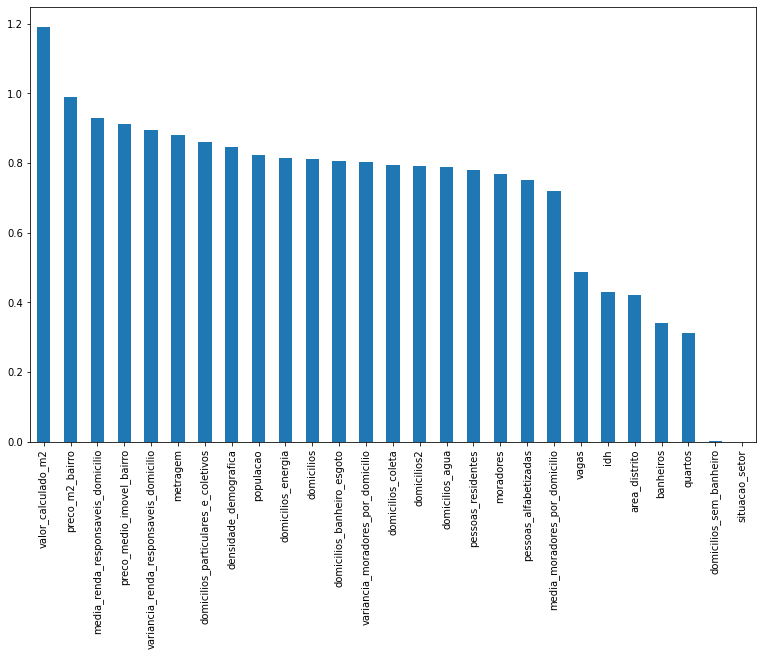

In [ ]:
mi_series.sort_values(ascending = False).plot.bar(figsize = (13,8))

In [ ]:
sel = SelectPercentile(mutual_info_regression, percentile = 75).fit(X_train, y_train)
colunas_mi = X_train.columns[sel.get_support()]
colunas_mi

Index(['metragem', 'domicilios', 'moradores', 'media_moradores_por_domicilio',
       'variancia_moradores_por_domicilio',
       'media_renda_responsaveis_domicilio',
       'variancia_renda_responsaveis_domicilio',
       'domicilios_particulares_e_coletivos', 'domicilios2', 'domicilios_agua',
       'domicilios_banheiro_esgoto', 'domicilios_coleta', 'domicilios_energia',
       'pessoas_alfabetizadas', 'pessoas_residentes', 'populacao',
       'densidade_demografica', 'preco_m2_bairro', 'preco_medio_imovel_bairro',
       'valor_calculado_m2'],
      dtype='object')

In [ ]:
X_train_mi = X_train[colunas_mi]
X_train.shape, X_train_mi.shape

((550, 27), (550, 20))

In [ ]:
X_train_mi

,metragem,domicilios,moradores,media_moradores_por_domicilio,variancia_moradores_por_domicilio,media_renda_responsaveis_domicilio,variancia_renda_responsaveis_domicilio,domicilios_particulares_e_coletivos,domicilios2,domicilios_agua,domicilios_banheiro_esgoto,domicilios_coleta,domicilios_energia,pessoas_alfabetizadas,pessoas_residentes,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,valor_calculado_m2
1969,396.0,109.0,367.0,3.37,2.36,12502.68,1.807693e+08,109.0,109.0,109.0,109.0,109.0,109.0,346.0,367.0,43117.0,5600.00,12933.0,4320923.0,5121468.0
4012,536.0,111.0,391.0,3.52,2.31,11176.49,4.180010e+08,112.0,111.0,111.0,107.0,111.0,111.0,371.0,392.0,43117.0,5600.00,12933.0,4320923.0,6932088.0
4590,340.0,192.0,480.0,2.50,1.80,7630.26,4.286337e+07,192.0,192.0,192.0,192.0,192.0,192.0,456.0,480.0,65752.0,7472.00,11633.0,2202806.0,3955220.0
2546,466.0,109.0,367.0,3.37,2.36,12502.68,1.807693e+08,109.0,109.0,109.0,109.0,109.0,109.0,346.0,367.0,43117.0,5600.00,12933.0,4320923.0,6026778.0
2240,570.0,123.0,404.0,3.28,2.07,13292.70,1.570580e+08,123.0,123.0,123.0,123.0,123.0,123.0,390.0,404.0,43117.0,5600.00,12933.0,4320923.0,7371810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1000.0,62.0,231.0,3.73,2.69,35612.90,7.163385e+08,62.0,62.0,61.0,60.0,62.0,62.0,222.0,231.0,46957.0,4119.00,7537.0,3565702.0,7537000.0
817,1100.0,48.0,164.0,3.42,2.76,10556.25,1.671157e+08,48.0,48.0,48.0,48.0,48.0,48.0,148.0,164.0,46957.0,4119.00,7537.0,3565702.0,8290700.0
2003,499.0,98.0,345.0,3.52,2.48,11993.64,2.660192e+08,98.0,98.0,98.0,95.0,98.0,98.0,332.0,345.0,46957.0,4119.00,7537.0,3565702.0,3760963.0
3176,242.0,133.0,415.0,3.12,1.58,6495.86,3.710076e+07,133.0,133.0,133.0,133.0,133.0,133.0,403.0,415.0,130484.0,15.17,8042.0,1253433.0,1946164.0


## 4.2 Qui - Quadrado

In [ ]:
f_score = chi2(X_train.fillna(0), y_train)
f_score

(array([5.62954403e+04, 8.83344813e+01, 2.41611423e+02, 4.35482207e+02,
        3.08970521e-30, 5.42388276e+03, 1.51449462e+04, 1.63677976e+01,
        4.70447597e+01, 2.70902111e+06, 2.68811719e+11, 5.80762367e+03,
        5.42388276e+03, 5.43702252e+03, 5.48411401e+03, 1.12437500e+03,
        5.42642502e+03, 5.42409500e+03, 1.43317232e+04, 1.53794202e+04,
        2.32481644e-01, 1.35079947e+07, 3.87977118e+06, 8.17263989e+05,
        3.30734731e+05, 4.91774853e+08, 1.22293904e+09]),
 array([0.00000000e+000, 1.00000000e+000, 8.77596089e-003, 5.92619102e-021,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.41216702e-131,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+

In [ ]:
p_values = pd.Series(f_score[1])
p_values.index = X_train.columns
p_values.sort_values(ascending = True)

metragem                                   0.000000e+00
preco_m2_bairro                            0.000000e+00
densidade_demografica                      0.000000e+00
populacao                                  0.000000e+00
area_distrito                              0.000000e+00
pessoas_residentes                         0.000000e+00
pessoas_alfabetizadas                      0.000000e+00
domicilios_energia                         0.000000e+00
domicilios_coleta                          0.000000e+00
domicilios_banheiro_esgoto                 0.000000e+00
preco_medio_imovel_bairro                  0.000000e+00
domicilios2                                0.000000e+00
domicilios_agua                            0.000000e+00
variancia_renda_responsaveis_domicilio     0.000000e+00
media_renda_responsaveis_domicilio         0.000000e+00
moradores                                  0.000000e+00
domicilios                                 0.000000e+00
domicilios_particulares_e_coletivos        0.000

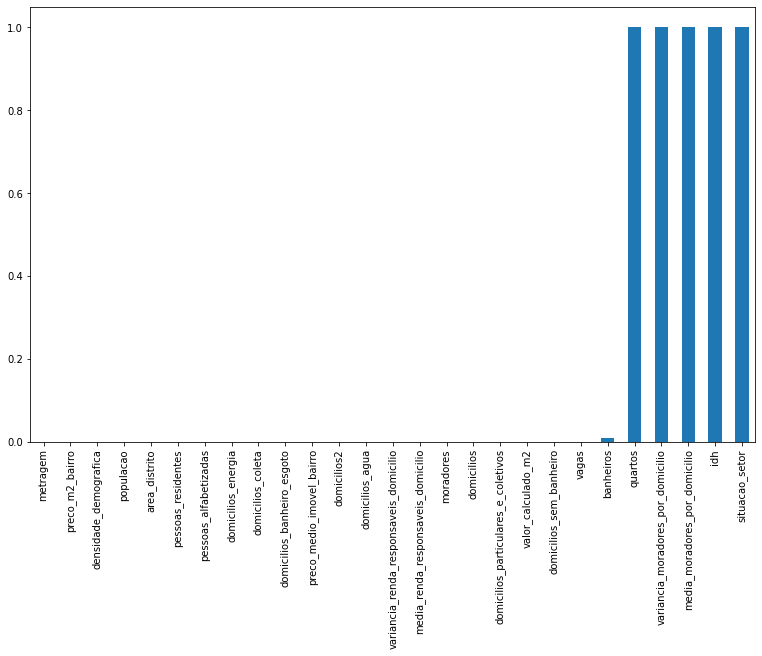

In [ ]:
p_values.sort_values(ascending = True).plot.bar(figsize = (13,8))

In [ ]:
sel_qui = SelectPercentile(chi2, percentile = 75).fit(X_train.fillna(0), y_train)
colunas_qui = X_train.columns[sel_qui.get_support()]
colunas_qui

Index(['metragem', 'domicilios', 'moradores',
       'media_renda_responsaveis_domicilio',
       'variancia_renda_responsaveis_domicilio',
       'domicilios_particulares_e_coletivos', 'domicilios2', 'domicilios_agua',
       'domicilios_banheiro_esgoto', 'domicilios_sem_banheiro',
       'domicilios_coleta', 'domicilios_energia', 'pessoas_alfabetizadas',
       'pessoas_residentes', 'area_distrito', 'populacao',
       'densidade_demografica', 'preco_m2_bairro', 'preco_medio_imovel_bairro',
       'valor_calculado_m2'],
      dtype='object')

In [ ]:
X_train_qui = X_train[colunas_qui]
X_train.shape, X_train_qui.shape

((550, 27), (550, 20))

In [ ]:
X_train_qui

,metragem,domicilios,moradores,media_renda_responsaveis_domicilio,variancia_renda_responsaveis_domicilio,domicilios_particulares_e_coletivos,domicilios2,domicilios_agua,domicilios_banheiro_esgoto,domicilios_sem_banheiro,domicilios_coleta,domicilios_energia,pessoas_alfabetizadas,pessoas_residentes,area_distrito,populacao,densidade_demografica,preco_m2_bairro,preco_medio_imovel_bairro,valor_calculado_m2
1969,396.0,109.0,367.0,12502.68,1.807693e+08,109.0,109.0,109.0,109.0,0.0,109.0,109.0,346.0,367.0,7.7,43117.0,5600.00,12933.0,4320923.0,5121468.0
4012,536.0,111.0,391.0,11176.49,4.180010e+08,112.0,111.0,111.0,107.0,0.0,111.0,111.0,371.0,392.0,7.7,43117.0,5600.00,12933.0,4320923.0,6932088.0
4590,340.0,192.0,480.0,7630.26,4.286337e+07,192.0,192.0,192.0,192.0,0.0,192.0,192.0,456.0,480.0,8.8,65752.0,7472.00,11633.0,2202806.0,3955220.0
2546,466.0,109.0,367.0,12502.68,1.807693e+08,109.0,109.0,109.0,109.0,0.0,109.0,109.0,346.0,367.0,7.7,43117.0,5600.00,12933.0,4320923.0,6026778.0
2240,570.0,123.0,404.0,13292.70,1.570580e+08,123.0,123.0,123.0,123.0,0.0,123.0,123.0,390.0,404.0,7.7,43117.0,5600.00,12933.0,4320923.0,7371810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1000.0,62.0,231.0,35612.90,7.163385e+08,62.0,62.0,61.0,60.0,0.0,62.0,62.0,222.0,231.0,11.4,46957.0,4119.00,7537.0,3565702.0,7537000.0
817,1100.0,48.0,164.0,10556.25,1.671157e+08,48.0,48.0,48.0,48.0,0.0,48.0,48.0,148.0,164.0,11.4,46957.0,4119.00,7537.0,3565702.0,8290700.0
2003,499.0,98.0,345.0,11993.64,2.660192e+08,98.0,98.0,98.0,95.0,0.0,98.0,98.0,332.0,345.0,11.4,46957.0,4119.00,7537.0,3565702.0,3760963.0
3176,242.0,133.0,415.0,6495.86,3.710076e+07,133.0,133.0,133.0,133.0,0.0,133.0,133.0,403.0,415.0,8.6,130484.0,15.17,8042.0,1253433.0,1946164.0


## 4.3 ANOVA

In [ ]:
univariate = f_regression(X_train.fillna(0), y_train)

univariate = pd.Series(univariate[1])

univariate.index = X_train.columns
univariate.sort_values(ascending = True, inplace = True)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [ ]:
univariate.sort_values(ascending = True)

valor_calculado_m2                        6.620240e-159
metragem                                   3.604466e-85
preco_m2_bairro                            3.363703e-43
vagas                                      9.052231e-36
preco_medio_imovel_bairro                  1.299214e-31
media_renda_responsaveis_domicilio         4.212725e-22
banheiros                                  1.603022e-19
populacao                                  1.276777e-15
idh                                        3.954908e-15
domicilios_agua                            6.845799e-10
domicilios2                                6.921184e-10
domicilios                                 6.921184e-10
domicilios_energia                         6.957476e-10
domicilios_coleta                          7.369325e-10
domicilios_banheiro_esgoto                 1.125505e-09
domicilios_particulares_e_coletivos        4.372622e-09
moradores                                  1.900596e-07
pessoas_residentes                         2.117

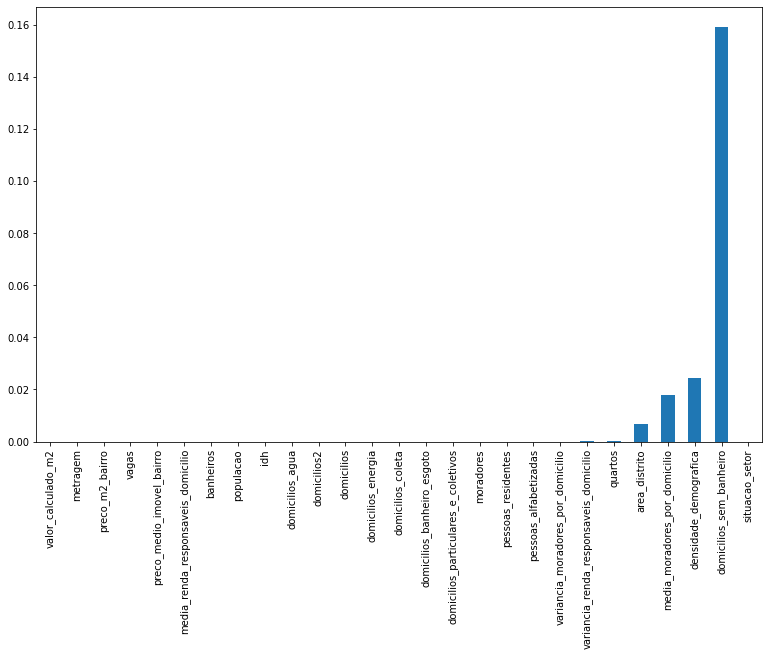

In [ ]:
univariate.plot.bar(figsize = (13,8))

In [ ]:
sel_anova = SelectPercentile(f_regression, percentile = 75).fit(X_train.fillna(0), y_train)
colunas_anova = X_train.columns[sel_anova.get_support()]
colunas_anova

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


Index(['metragem', 'banheiros', 'vagas', 'domicilios', 'moradores',
       'variancia_moradores_por_domicilio',
       'media_renda_responsaveis_domicilio',
       'domicilios_particulares_e_coletivos', 'domicilios2', 'domicilios_agua',
       'domicilios_banheiro_esgoto', 'domicilios_coleta', 'domicilios_energia',
       'pessoas_alfabetizadas', 'pessoas_residentes', 'idh', 'populacao',
       'preco_m2_bairro', 'preco_medio_imovel_bairro', 'valor_calculado_m2'],
      dtype='object')

In [ ]:
X_train_anova = X_train[colunas_anova]
X_train.shape, X_train_anova.shape

((550, 27), (550, 20))

In [ ]:
X_train_anova

,metragem,banheiros,vagas,domicilios,moradores,variancia_moradores_por_domicilio,media_renda_responsaveis_domicilio,domicilios_particulares_e_coletivos,domicilios2,domicilios_agua,domicilios_banheiro_esgoto,domicilios_coleta,domicilios_energia,pessoas_alfabetizadas,pessoas_residentes,idh,populacao,preco_m2_bairro,preco_medio_imovel_bairro,valor_calculado_m2
1969,396.0,5.0,4.0,109.0,367.0,2.36,12502.68,109.0,109.0,109.0,109.0,109.0,109.0,346.0,367.0,0.96,43117.0,12933.0,4320923.0,5121468.0
4012,536.0,4.0,4.0,111.0,391.0,2.31,11176.49,112.0,111.0,111.0,107.0,111.0,111.0,371.0,392.0,0.96,43117.0,12933.0,4320923.0,6932088.0
4590,340.0,4.0,5.0,192.0,480.0,1.80,7630.26,192.0,192.0,192.0,192.0,192.0,192.0,456.0,480.0,0.94,65752.0,11633.0,2202806.0,3955220.0
2546,466.0,6.0,6.0,109.0,367.0,2.36,12502.68,109.0,109.0,109.0,109.0,109.0,109.0,346.0,367.0,0.96,43117.0,12933.0,4320923.0,6026778.0
2240,570.0,7.0,9.0,123.0,404.0,2.07,13292.70,123.0,123.0,123.0,123.0,123.0,123.0,390.0,404.0,0.96,43117.0,12933.0,4320923.0,7371810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1000.0,8.0,6.0,62.0,231.0,2.69,35612.90,62.0,62.0,61.0,60.0,62.0,62.0,222.0,231.0,0.94,46957.0,7537.0,3565702.0,7537000.0
817,1100.0,6.0,8.0,48.0,164.0,2.76,10556.25,48.0,48.0,48.0,48.0,48.0,48.0,148.0,164.0,0.94,46957.0,7537.0,3565702.0,8290700.0
2003,499.0,8.0,5.0,98.0,345.0,2.48,11993.64,98.0,98.0,98.0,95.0,98.0,98.0,332.0,345.0,0.94,46957.0,7537.0,3565702.0,3760963.0
3176,242.0,4.0,3.0,133.0,415.0,1.58,6495.86,133.0,133.0,133.0,133.0,133.0,133.0,403.0,415.0,0.95,130484.0,8042.0,1253433.0,1946164.0


# 5 Modelos de regressão

## 5.1 Regressão Linear

In [ ]:
reg = LinearRegression().fit(X_train_mi, y_train) #(X_train_scaled, y_train)
y_test_pred  = reg.predict(X_test[colunas_mi])
y_test_pred

array([ 2.96460221e+06,  5.62906172e+06,  5.23982599e+06,  7.15336117e+06,
        3.86942897e+06,  2.72114641e+06,  1.47406105e+05,  3.75128308e+06,
        2.07746872e+06,  2.43408187e+06,  6.01949508e+05,  4.05350886e+06,
        1.28585785e+06,  7.52968531e+06,  1.08467509e+06,  2.01352290e+06,
        7.96866340e+06,  4.20109997e+06,  1.19610603e+05,  3.38024953e+06,
       -6.58615363e+05,  1.91433344e+06,  1.88674177e+06,  2.79066451e+06,
        5.21524249e+05,  1.39550451e+06,  1.01685096e+06,  4.63429915e+06,
        2.57443231e+06,  3.51697025e+06,  2.89639173e+06,  4.34592149e+06,
        1.09623004e+06,  5.72922680e+06,  3.30345527e+06,  4.66819707e+06,
        5.43213151e+06,  5.16135353e+06,  3.76010537e+06,  7.72080019e+06,
        4.77751051e+05,  8.56413609e+05,  2.47404648e+06,  3.09725315e+06,
        2.54196611e+06,  1.14101001e+06,  2.95928670e+06,  2.97480349e+06,
        3.13320364e+06,  1.35440834e+06,  8.50598957e+05,  3.13268729e+06,
        2.96044894e+06,  

In [ ]:
df_results_reg_lin = pd.DataFrame(list(zip(y_test_pred, y_test)), columns = ['y_test_pred','y_test'])
df_results_reg_lin = df_results_reg_lin.astype(int)
df_results_reg_lin

,y_test_pred,y_test
0,2964602,1950000
1,5629061,5850000
2,5239825,3500000
3,7153361,5900000
4,3869428,3700000
...,...,...
267,2237058,2500000
268,1504784,2400000
269,2402740,4800000
270,1093459,899990


In [ ]:
df_results_reg_lin.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_results_reg_lin_mi75.csv')

## 5.2 Random Forest

### 5.2.1 Sem tunagem

In [ ]:
regr = RandomForestRegressor(n_estimators = 500,
                             #max_depth = 2,
                             random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

In [ ]:
y_test_pred_rf = regr.predict(X_test)

df_results_random_forest = pd.DataFrame(list(zip(y_test_pred_rf, y_test)), columns = ['y_test_pred_rf','y_test'])
df_results_random_forest = df_results_random_forest.astype(int)
df_results_random_forest

,y_test_pred_rf,y_test
0,2665260,3800000
1,7016912,10500000
2,3143729,2000000
3,3243270,3600000
4,4616991,5500000
...,...,...
2957,541240,470000
2958,1958854,800000
2959,4875970,3800000
2960,615433,645000


In [ ]:
df_results_random_forest.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_results_random_forest_mais_dados3.csv')

### 5.2.2 Com tunagem

In [ ]:
gs_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 0),
                                  param_grid = {'n_estimators': [100, 200, 300, 500, 800, 1300],
                                                'max_depth': [None, 100, 300], # substituir por valores menores [3, 5, 8, 10]
                                                'min_samples_split': [2, 5],
                                                'min_samples_leaf': [1, 2, 3]},
                                  scoring='neg_mean_squared_error',
                                  cv = 3,
                                  verbose=4)
#{'max_depth': None,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 1300}

gs_rf.fit(X_train, y_train)

gs_dict_rf = gs_rf.cv_results_
gs_results_rf = pd.DataFrame(gs_dict_rf)
gs_results_rf.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/gs_results_rf1.csv')

gs_rf.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-2232495124040.331 total time=   0.4s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-4675675302149.963 total time=   0.4s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-1791612398912.041 total time=   0.4s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-2108445368376.771 total time=   0.7s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-4468512193035.206 total time=   0.7s
[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1819741963054.705 total time=   0.7s
[CV 1/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=-2142777415737.144 total time=   1.1s
[CV 2/

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1300}

In [ ]:
gs_results_rf = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/gs_results_rf1.csv')
gs_results_rf

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0,0.359499,0.006099,0.010860,0.000750,NaN,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-2.232495e+12,-4.675675e+12,-1.791612e+12,-2.899928e+12,1.268478e+12,46
1,1,0.703071,0.007641,0.020547,0.000314,NaN,1,2,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-2.108445e+12,-4.468512e+12,-1.819742e+12,-2.798900e+12,1.186463e+12,7
2,2,1.066417,0.005644,0.030688,0.000810,NaN,1,2,300,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-2.142777e+12,-4.498788e+12,-1.840696e+12,-2.827420e+12,1.188252e+12,22
3,3,1.771519,0.017380,0.048706,0.000751,NaN,1,2,500,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-2.143436e+12,-4.500449e+12,-1.788974e+12,-2.810953e+12,1.203386e+12,10
4,4,2.799594,0.024534,0.084012,0.004947,NaN,1,2,800,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-2.108087e+12,-4.417229e+12,-1.769978e+12,-2.765098e+12,1.176360e+12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.594498,0.015879,0.021013,0.000714,300.0,3,5,200,"{'max_depth': 300, 'min_samples_leaf': 3, 'min...",-2.535609e+12,-4.778605e+12,-1.856420e+12,-3.056878e+12,1.248621e+12,85
104,104,0.880697,0.013993,0.028536,0.002125,300.0,3,5,300,"{'max_depth': 300, 'min_samples_leaf': 3, 'min...",-2.528687e+12,-4.909976e+12,-1.854392e+12,-3.097685e+12,1.310717e+12,103
105,105,1.467869,0.024746,0.042148,0.001479,300.0,3,5,500,"{'max_depth': 300, 'min_samples_leaf': 3, 'min...",-2.467723e+12,-4.880597e+12,-1.831555e+12,-3.059958e+12,1.313322e+12,91
106,106,2.330044,0.002116,0.066087,0.000895,300.0,3,5,800,"{'max_depth': 300, 'min_samples_leaf': 3, 'min...",-2.465103e+12,-4.759966e+12,-1.817432e+12,-3.014167e+12,1.262466e+12,73


### 5.2.3 Melhor RF

In [ ]:
{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1300}

regr = RandomForestRegressor(n_estimators = 1300,
                             max_depth = None,
                             min_samples_leaf = 1,
                             min_samples_split = 2,
                             random_state=0)
regr.fit(X_train, y_train)

y_test_pred_rf = regr.predict(X_test)

df_results_random_forest = pd.DataFrame(list(zip(y_test_pred_rf, y_test)), columns = ['y_test_pred_rf','y_test'])
df_results_random_forest = df_results_random_forest.astype(int)
df_results_random_forest

,y_test_pred_rf,y_test
0,1992586,1950000
1,11244090,5850000
2,4776944,3500000
3,5948746,5900000
4,3215407,3700000
...,...,...
267,2688784,2500000
268,2207417,2400000
269,4272399,4800000
270,1276026,899990


In [ ]:
df_results_random_forest.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_results_random_forest_melhor.csv')

## 5.3 XGBoost

### 5.3.1 Sem tunagem

In [ ]:
xgb_model = xgb.XGBRegressor(n_jobs=1,
                             max_depth = 4,
                             n_estimators = 100)
xgb_model = xgb_model.fit(X_train, y_train)

[02:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_test_pred_xg = xgb_model.predict(X_test)

df_results_xg = pd.DataFrame(list(zip(y_test_pred_xg, y_test)), columns = ['y_test_pred_xg','y_test'])
df_results_xg = df_results_xg.astype(int)
df_results_xg

,y_test_pred_xg,y_test
0,974626,3800000
1,5662952,10500000
2,3302244,2000000
3,2409823,3600000
4,3773974,5500000
...,...,...
2957,556464,470000
2958,1695658,800000
2959,5821940,3800000
2960,536030,645000


In [ ]:
df_results_xg.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_results_xg_mais_dados3.csv')

### 5.3.2 Com tunagem

In [ ]:
gs_xg = GridSearchCV(estimator = xgb.XGBRegressor(random_state = 0),
                                  param_grid = {'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.08, 0.13], # subir pq bateu na trave
                                                'n_estimators': [100, 200, 300, 500, 800, 1300],
                                                'max_depth': [3, 5],
                                                'gpu_id': ['0'],
                                                'tree_method': ['gpu_hist'],
                                                'min_child_weigth': [1, 3],
                                                'subsample': [1, 0.75],
                                                'colsample_bytree': [1, 0.75]}, # inserir 0.5 e pela raiz
                                  scoring='neg_mean_squared_error',
                                  cv = 3,
                                  verbose=4)

#{'colsample_bytree': 0.75,
#'gpu_id': '0',
# 'learning_rate': 0.13,
# 'max_depth': 3,
# 'min_child_weigth': 1,
# 'n_estimators': 200,
# 'subsample': 0.75,
# 'tree_method': 'gpu_hist'}

gs_xg.fit(X_train, y_train)

gs_dict_xg = gs_xg.cv_results_
gs_results_xg = pd.DataFrame(gs_dict_xg)
gs_results_xg.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/gs_results_xg1.csv')

gs_xg.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[04:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/3] END colsample_bytree=1, gpu_id=0, learning_rate=0.01, max_depth=3, min_child_weigth=1, n_estimators=100, subsample=1, tree_method=gpu_hist;, score=-7754661917000.144 total time=   0.4s
[04:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/3] END colsample_bytree=1, gpu_id=0, learning_rate=0.01, max_depth=3, min_child_weigth=1, n_estimators=100, subsample=1, tree_method=gpu_hist;, score=-10016314896457.914 total time=   0.6s
[04:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/3] END colsample_bytree=1, gpu_id=0, learning_rate=0.01, max_depth=3, min_child_weigth=1, n_estimators=100, subsample=1, tree_method=gpu_hist;, score=-434456926

{'colsample_bytree': 0.75,
 'gpu_id': '0',
 'learning_rate': 0.13,
 'max_depth': 3,
 'min_child_weigth': 1,
 'n_estimators': 200,
 'subsample': 0.75,
 'tree_method': 'gpu_hist'}

### 5.3.3 Melhor XG

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.13,
                              max_depth = 3,
                              min_child_weigth = 1,
                              n_estimators = 200,
                              subsample = 0.75)
xgb_model = xgb_model.fit(X_train, y_train)

y_test_pred_xg = xgb_model.predict(X_test)

df_results_xg = pd.DataFrame(list(zip(y_test_pred_xg, y_test)), columns = ['y_test_pred_xg','y_test'])
df_results_xg = df_results_xg.astype(int)
df_results_xg

[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,y_test_pred_xg,y_test
0,1935327,1950000
1,8920682,5850000
2,4984316,3500000
3,5548838,5900000
4,3641876,3700000
...,...,...
267,2823951,2500000
268,2218254,2400000
269,4099308,4800000
270,1252857,899990


In [ ]:
df_results_xg.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_results_xg_melhor.csv')

## 5.4 Rede Neural

In [ ]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_rn, X_test_rn, y_train_rn, y_test_rn = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(X_train_rn, y_train_rn, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_rn = scaler.fit_transform(X_train_rn)
X_valid_rn = scaler.transform(X_valid_rn)
X_test_rn = scaler.transform(X_test_rn)

In [ ]:
model = keras.models.Sequential([
 keras.layers.Dense(100, input_shape=X_train_rn.shape[1:]),
 keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")

history = model.fit(X_train_rn, y_train_rn, epochs=100, validation_data=(X_valid_rn, y_valid_rn))

Epoch 1/100
17/17 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 9/100
17/17 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 11/100
17/17 [==============================] - 0s 6ms/step - 

In [ ]:
mse_test = model.evaluate(X_test_rn, y_test_rn)
X_new = X_test_rn[:3] # pretend these are new instances
y_pred = model.predict(X_new)
y_pred

6/6 [==============================] - 0s 3ms/step - loss: nan


array([[nan],
       [nan],
       [nan]], dtype=float32)

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=X_train_rn.shape[1:]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1792      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
  X_train_rn, y_train_rn,
  epochs=100, validation_split = 0.2, validation_data=(X_valid_rn, y_valid_rn))

Epoch 1/100
14/14 [==============================] - 0s 12ms/step - loss: 23855148040192.0000 - mae: 3382116.2500 - mse: 23855148040192.0000 - val_loss: 12383512690688.0000 - val_mae: 2808641.7500 - val_mse: 12383512690688.0000
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 23817523036160.0000 - mae: 3378148.0000 - mse: 23817523036160.0000 - val_loss: 12353520271360.0000 - val_mae: 2804330.7500 - val_mse: 12353520271360.0000
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 23780883693568.0000 - mae: 3374508.0000 - mse: 23780883693568.0000 - val_loss: 12325685821440.0000 - val_mae: 2800317.5000 - val_mse: 12325685821440.0000
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 23743134957568.0000 - mae: 3370764.2500 - mse: 23743134957568.0000 - val_loss: 12294219104256.0000 - val_mae: 2795815.0000 - val_mse: 12294219104256.0000
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 23705329598464.000

In [ ]:
mse_test = model.evaluate(X_test_rn, y_test_rn)
X_new = X_test_rn[:3] # pretend these are new instances
y_pred = model.predict(X_new)
y_pred

6/6 [==============================] - 0s 4ms/step - loss: 10434590539776.0000 - mae: 2373228.2500 - mse: 10434590539776.0000


array([[ 660512.1],
       [1817523.6],
       [1384277. ]], dtype=float32)

In [ ]:
y_test_pred_xg = xgb_model.predict(X_test)

df_results_xg = pd.DataFrame(list(zip(y_test_pred_xg, y_test)), columns = ['y_test_pred_xg','y_test'])
df_results_xg = df_results_xg.astype(int)
df_results_xg

# 6 Tunagem

## 6.1 Criação de uma métrica customizada

In [ ]:
def custom_score_function(y_true, y_pred):

    percentual_acertos = np.sum(abs(y_true - y_pred) <= 0.1 * y_true) / y_true.size
    return percentual_acertos

In [ ]:
scorer = make_scorer(custom_score_function, greater_is_better=True)
scorer

make_scorer(custom_score_function)

Testando o scorer:

In [ ]:
gs_rf = GridSearchCV(RandomForestRegressor(random_state = 0),
                                  param_grid = {'n_estimators': [100, 200]},
                                  scoring = scorer,
                                  cv = 3,
                                  verbose=4)

gs_rf.fit(X_train, y_train)

gs_dict_rf = gs_rf.cv_results_
gs_results_rf = pd.DataFrame(gs_dict_rf)

gs_rf.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ..................n_estimators=100;, score=0.376 total time=   5.2s
[CV 2/3] END ..................n_estimators=100;, score=0.371 total time=   5.1s
[CV 3/3] END ..................n_estimators=100;, score=0.382 total time=   5.2s
[CV 1/3] END ..................n_estimators=200;, score=0.374 total time=  10.2s
[CV 2/3] END ..................n_estimators=200;, score=0.377 total time=  10.2s
[CV 3/3] END ..................n_estimators=200;, score=0.393 total time=  10.3s


{'n_estimators': 200}

In [ ]:
def custom_score_function_penalty(y_true, y_pred):
    '''
    erro_para_menos = max(y_true - y_pred, 0)
    erro_para_mais = max(y_pred - y_true, 0)

    peso_menos = 10 # tol 10%
    peso_mais = 5 # tol 20%
    
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
    '''
    percentual_acertos = np.sum([1 if x % 2 == 0 for x in l])
    return percentual_acertos

In [ ]:
y_true = [10, 20, 30]
y_pred = [11, 19, 40]

#f = lambda x, y: x*x
#[f(x) for x in range(10)]

#np.sum([max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true])
(abs(y_true - y_pred) <= 0.1 * y_true) / y_true.size

TypeError: ignored

In [ ]:
def custom_score_function_penalty(y_true, y_pred):

    percentual_acertos = np.sum(abs(y_true - y_pred) <= 0.1 * y_true) / y_true.size
    return percentual_acertos

In [ ]:
scorer_penalty = make_scorer(custom_score_function_penalty, greater_is_better=True)
scorer_penalty

make_scorer(custom_score_function_penalty)

In [ ]:
gs_rf = GridSearchCV(RandomForestRegressor(random_state = 0),
                                  param_grid = {'n_estimators': [100, 200]},
                                  scoring = scorer_penalty,
                                  cv = 3,
                                  verbose=4)

gs_rf.fit(X_train, y_train)

gs_dict_rf = gs_rf.cv_results_
gs_results_rf = pd.DataFrame(gs_dict_rf)

gs_rf.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 1/3] END ....................n_estimators=100;, score=nan total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 2/3] END ....................n_estimators=100;, score=nan total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 3/3] END ....................n_estimators=100;, score=nan total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 1/3] END ....................n_estimators=200;, score=nan total time=  10.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 2/3] END ....................n_estimators=200;, score=nan total time=  10.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-17-52f971c0537e>", line 9, in custom_score_function_penalty
    percentual_acertos = np.sum(max(y_true - y_pred, 0) * 10 + max(y_pred - y_true, 0) * 5 <= y_true) / y_true.size
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py", line 1538, in __nonzero__
    f"The t

[CV 3/3] END ....................n_estimators=200;, score=nan total time=  10.3s


{'n_estimators': 100}

## 6.1 Random Forest

Teoria: https://www.youtube.com/watch?v=80hT0_8LTGU&ab_channel=RafaelIzbicki

Prática: https://www.youtube.com/watch?v=RtA1rjhuavs&ab_channel=MarioFilhoBrasil

Explorando os hiperparâmetros:

In [ ]:
regr = RandomForestRegressor(n_estimators = 3400,
                             min_samples_leaf = 1,
                             max_depth = 32,
                             max_features = 'log2',
                             bootstrap = False,
                             random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

custom_score_function(y_test, y_pred)

0.5104659014179609

In [ ]:
n_estimators = 50, msl = 1  ---> 0.3723835246455098, usando bootstrap = False ---> 0.5030384875084403
n_estimators = 100, msl = 1 ---> 0.37913571910871036
n_estimators = 200, msl = 1 ---> 0.3808237677245105, usando bootstrap = False ---> 0.5040513166779204
n_estimators = 300, msl = 1 ---> 0.3801485482781904
n_estimators = 500, msl = 1 ---> 0.37812288993923027, usando bootstrap = False ---> 0.5108035111411209
n_estimators = 800, msl = 1 ---> 0.3777852802160702
n_estimators = 1300, msl = 1 ---> 0.37913571910871036

# usando msl = 2 os resultados pioraram. Isso significa que obtemos resultados melhores com árvores mais profundas
n_estimators = 50, msl = 2  ---> 0.3507765023632681, usando bootstrap = False ---> 0.39905469277515193
n_estimators = 100, msl = 2 ---> 0.36664415935178934
n_estimators = 200, msl = 2 ---> 0.36664415935178934
n_estimators = 300, msl = 2 ---> 0.36293045239702904
n_estimators = 500, msl = 2 ---> 0.3602295746117488, usando bootstrap = False ---> 0.39905469277515193
n_estimators = 800, msl = 2 ---> 0.36191762322754895
n_estimators = 1300, msl = 2 ---> 0.36293045239702904

# usando msl = 3 os resultados pioraram ainda mais
n_estimators = 500, msl = 3, bootstrap = False ---> 0.3575286968264686
n_estimators = 1100, msl = 3, bootstrap = False ---> 0.3561782579338285

# usando log2 para a seleção das variáveis, tivemos resultados melhores do que usando o default, que é sqrt
n_estimators = 1300, msl = 1, max_features = 'log2' ---> 0.4034436191762323 # usando sqrt: sqrt(28) = 5.29 = 5; log2(28) = 4.8 = 5

# usando bootstrap = False, utilizamos todo o conjunto de treino na construção de cada árvore
# Isso ficou muito melhor do que bootstrap = True, que usa uma amostra com reposição do conj de treino para construir cada árvore
# em geral, o max_death reduziu o desempenho ou manteve igual. Na média, as árvores parecem ter cerca de 28 - 32 nós, porque a partir disso o desempenho quase não muda
n_estimators = 1300, msl = 1, max_features = 'log2', bootstrap = False ---> 0.5111411208642809, usando max_depth = 14 ---> 0.3713, 20 ---> 0.4952, 24 ---> 0.5094, 28 ---> 0.5124, 32 ---> 0.5104, 56 ou 100 ---> 0.5111
n_estimators = 2100, msl = 1, max_features = 'log2', bootstrap = False ---> 0.5104659014179609
n_estimators = 3400, msl = 1, max_features = 'log2', bootstrap = False ---> 0.513166779203241, usando max_depth = 14 ---> 0.3720, 20 ---> 0.4952, 28 ---> 0.5131, 32 ---> 0.5104
n_estimators = 3400, msl = 1, max_features = 'sqrt', bootstrap = False ---> 0.5084402430790007

# usando max_features = None (sem seleção de variáveis; cada árvore usa todas as variáveis) tivemos resultados piores e o tempo de treinamento aumentou muito (quase o dobro por treino)
# isso significa que a seleção de variáveis estava ajudando, talvez porque aumenta a variabilidade das árvores
n_estimators = 1300, msl = 1, max_features = None, bootstrap = False ---> 0.46421336934503715
n_estimators = 2100, msl = 1, max_features = None, bootstrap = False ---> 0.46421336934503715

Fazendo o gridsearch:

In [ ]:
# (5*2*2*2*2) * 2 (cv) * 2 min / 60 = 5.3 horas aproximadamente
gs_rf = GridSearchCV(RandomForestRegressor(random_state = 0),
                                  param_grid = {'n_estimators': [100, 300, 800, 3400, 5500],
                                                'min_samples_leaf': [1, 2],
                                                'max_features': ['sqrt', 'log2'],
                                                'bootstrap': [False, True]},
                                                #'max_death': [28, None]},
                                  scoring = scorer,
                                  cv = 2,
                                  verbose=4)

gs_rf.fit(X_train, y_train)

gs_dict_rf = gs_rf.cv_results_
gs_results_rf = pd.DataFrame(gs_dict_rf)
gs_results_rf.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/tunagem_rf.csv')

gs_rf.best_params_

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.399 total time=   1.2s
[CV 2/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=100;, score=0.413 total time=   1.0s
[CV 1/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=300;, score=0.403 total time=   2.9s
[CV 2/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=300;, score=0.416 total time=   2.9s
[CV 1/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=800;, score=0.404 total time=   7.7s
[CV 2/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=800;, score=0.418 total time=   7.7s
[CV 1/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=3400;, score=0.406 total time=  32.7s
[CV 2/2] END bootstrap=False, max_features=sqrt, min_samples_leaf=1, n_estimators=3400;, score=0.417 tota

{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 100}

## 6.2 XGBoost

Documentação: https://xgboost.readthedocs.io/en/stable/

Tunagem: https://www.youtube.com/watch?v=vp7sAKlf7FU&ab_channel=MarioFilhoBrasil

Vamos explorar os hiperparâmetros:

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.144, # 0.1 já é alto; geralmente lr menor dá mais estabilidade pro modelo
                             n_estimators = 2100, # número de árvores utilizadas
                             max_depth = 8,
                             min_child_weight = 1, # número mínimo de amostras necessárias à direita e à esquerda para abrir um novo nó. Quando aumentamos isso, a árvore fica mais rasa
                             subsample = 1, # é usada uma amostra do conjunto de treino para treinar cada árvore
                             colsample_bytree = 0.75,
                             gpu_id = '0',
                             tree_method = 'gpu_hist') # para usar a GPU; com a GPU, treinamentos de 3 min passaram a demorar 2 min aproximadamente
xgb_model = xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

custom_score_function(y_test, y_pred)

[04:49:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.43112761647535447

In [ ]:
# vamos começar com lr e n_estimators baixos:
lr = 0.0001, n_estimators = 100 ---> 0.0
lr = 0.001, n_estimators = 100 ---> 0.0
lr = 0.01, n_estimators = 100 ---> 0.12694125590817015

lr = 0.01, n_estimators = 200 ---> 0.21910871033085752
lr = 0.01, n_estimators = 300 ---> 0.23463875759621877
lr = 0.01, n_estimators = 500 ---> 0.24713031735313978
lr = 0.01, n_estimators = 800 ---> 0.2518568534773801
lr = 0.01, n_estimators = 1300 ---> 0.26029709655638084
lr = 0.01, n_estimators = 2100 ---> 0.26232275489534096
lr = 0.01, n_estimators = 3400 ---> 0.2765023632680621
lr = 0.01, n_estimators = 5500 ---> 0.29068197164078324
lr = 0.01, n_estimators = 8900 ---> 0.31093855503038487
lr = 0.01, n_estimators = 14400 ---> 0.33085752869682644
lr = 0.01, n_estimators = 23300 ---> 0.33727211343686697 # aumentamos muito o n_estimators e o score quase nao mudou, então não aumentaremos mais

lr = 0.001, n_estimators = 14400 ---> 0.25827143821742066 # diminuimos um pouco a lr já que o n_estimators está alto. Como o resultado piorou, vamos subir a lr aos poucos
lr = 0.002, n_estimators = 14400 ---> 0.27110060769750166
lr = 0.003, n_estimators = 14400 ---> 0.2839297771775827
lr = 0.005, n_estimators = 14400 ---> 0.3116137744767049
lr = 0.008, n_estimators = 14400 ---> 0.31600270087778526
lr = 0.013, n_estimators = 14400 ---> 0.33963538149898714
lr = 0.021, n_estimators = 14400 ---> 0.35010128291694803
lr = 0.034, n_estimators = 14400 ---> 0.3690074274139095
lr = 0.055, n_estimators = 14400 ---> 0.3858879135719109
lr = 0.089, n_estimators = 14400 ---> 0.39095205941931127
lr = 0.144, n_estimators = 14400 ---> 0.3983794733288319
lr = 0.233, n_estimators = 14400 ---> 0.3906144496961512 # aqui o score parou de subir, então ficaremos com o lr de 0.144

# aparentemente achamos valores bons para lr e n_estimators
lr = 0.144, n_estimators = 14400, max_depth = 5 ---> 0.40479405806887236
lr = 0.144, n_estimators = 14400, max_depth = 6 ---> 0.4169480081026334
lr = 0.144, n_estimators = 14400, max_depth = 7 ---> 0.4267386900742741
lr = 0.144, n_estimators = 14400, max_depth = 8 ---> 0.4395678595543552
lr = 0.144, n_estimators = 14400, max_depth = 9 ---> 0.43720459149223495 # aqui o score diminuiu, então usaremos max_depth = 8

# aumentando o min_child_weight, os resultados pioraram, talvez pq as árvores ficam mais rasas e precisamos de árvores mais profundas
lr = 0.144, n_estimators = 14400, max_depth = 8, min_child_weight = 2 ---> 0.4365293720459149
lr = 0.144, n_estimators = 14400, max_depth = 8, min_child_weight = 3 ---> 0.4297771775827144, subsample = 0.25 ---> 0.3737339635381499

# subsample só piorou os resultados, o melhor foi 0.75, mas ainda assim ficou abaixo dos resultados anteriores
lr = 0.144, n_estimators = 14400, max_depth = 8, subsample = 0.25 ---> 0.40310600945307223
lr = 0.144, n_estimators = 14400, max_depth = 8, subsample = 0.75 ---> 0.43315327481431465
lr = 0.144, n_estimators = 14400, max_depth = 8, subsample = 0.85 ---> 0.4264010803511141

# colsample_bytree
lr = 0.144, n_estimators = 14400, max_depth = 8, subsample = 1, colsample_bytree = 0.5 ---> 0.4216745442268737
lr = 0.144, n_estimators = 14400, max_depth = 8, subsample = 1, colsample_bytree = 0.75 ---> 0.4314652261985145

# lr e n_estimators costumam ser inversamente proporcionais

lr = 0.08, max_depth = 8, n_estimators = 8900 ---> 0.4385550303848751

In [ ]:
# (4*4*3*2*2*) * 2 (cv) * 2 min / 60 = 12.8 horas aproximadamente
gs_xg = GridSearchCV(estimator = xgb.XGBRegressor(random_state = 0),
                                  param_grid = {'learning_rate': [0.034, 0.089, 0.144, 0.233], 
                                                'n_estimators': [1300, 3400, 8900, 14400],
                                                'max_depth': [4, 6, 8],
                                                'gpu_id': ['0'],
                                                'tree_method': ['gpu_hist'],
                                                'min_child_weigth': [1],
                                                'subsample': [1, 0.75],
                                                'colsample_bytree': [1, 0.75]},
                                  scoring = scorer,
                                  cv = 2,
                                  verbose=4)

gs_xg.fit(X_train, y_train)

gs_dict_xg = gs_xg.cv_results_
gs_results_xg = pd.DataFrame(gs_dict_xg)
gs_results_xg.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/tunagem_xg.csv')

gs_xg.best_params_

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[12:25:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/2] END colsample_bytree=1, gpu_id=0, learning_rate=0.034, max_depth=4, min_child_weigth=1, n_estimators=1300, subsample=1, tree_method=gpu_hist;, score=0.275 total time=   7.7s
[12:25:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/2] END colsample_bytree=1, gpu_id=0, learning_rate=0.034, max_depth=4, min_child_weigth=1, n_estimators=1300, subsample=1, tree_method=gpu_hist;, score=0.283 total time=   7.0s
[12:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/2] END colsample_bytree=1, gpu_id=0, learning_rate=0.034, max_depth=4, min_child_weigth=1, n_estimators=1300, subsample=0.75, tree_method=gpu_hist;, score=0.277 total time=   7.1s
[12:

# 5 ---------------------------------

# 5 Anotações

* Tentar prever as colunas com nan (video discord)
* Usar um xgboost (OK)
* Tentar usar os 8k dados sem os dados do censo
* SVM ou redes neurais
* Random forests seleção de variáveis
* IDH e preço m2 por bairro (OK)

dia 08/07

* Tentativa 1: inserir uma coluna de NAO MISSING na base e substituir faltantes por 0

* Tentativa 2: excluir os missings nos dois casos (1º caso: sem variaveis novas e 2º caso com variaveis novas) (só para comparar nos mesmos dados)

dia 29/07

* Tentativa 1: Preencher os dados faltantes do ibge com a média da coluna para o respectivo bairro; os dados que não tiverem nenhuma amostra do bairro, serão preenchidos com a média do dataset todo

* Tentativa 2: https://scikit-learn.org/stable/modules/impute.html (univariada: subst pelos dados da coluna; multivariada: predizer os dados da coluna)

Roteiro: 1º melhoro as tecnicas acima, implementar a metrica personalizada, tunar os modelos, validar se os dados do ibge fazem diferença, terminar a rede neural, implementar uma penalização no score para que o modelo precifique mais para cima (para fomentar políticas de desconto eficientes)